In [ ]:
%pip install --quiet -U langgraph langchain_openai #langchain_core langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.2/471.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/208.3 kB 12.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 1.0.4 which is incompatible.


# **Agentic -LLMs and Augmentations (Tools, Structured Output, Memory)**

Workflows and agentic systems are based on LLMs and the various augmentations you add to them.

**Tool calling**, **structured outputs**, and **short term memory** are a few options for tailoring LLMs to your needs.

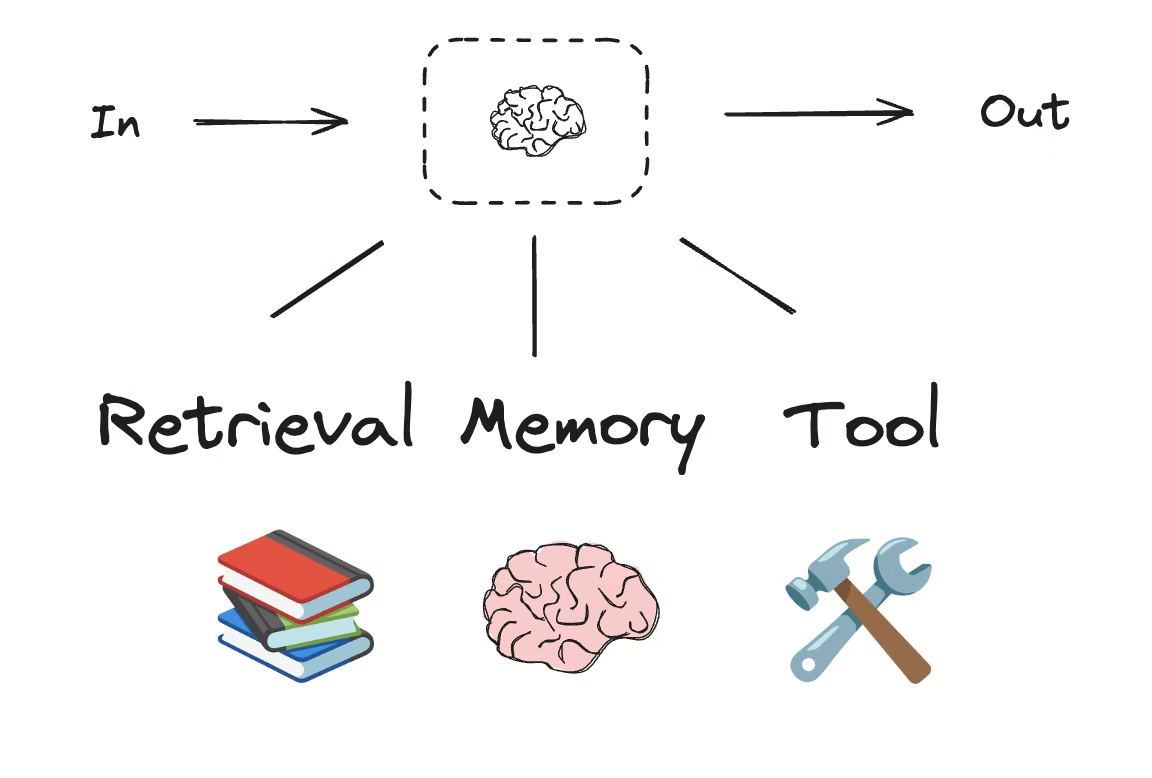

In [ ]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
# os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# **Structured Output**

In [ ]:
# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

In [ ]:
# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

In [ ]:
output

SearchQuery(search_query='Calcium CT score and high cholesterol relationship', justification='This query aims to find information on how calcium CT scores, which measure coronary artery calcification, relate to high cholesterol levels, as both are important factors in assessing cardiovascular health.')

# **Tool Use**

In [ ]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

In [ ]:
# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

print(msg)

content='' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 48, 'total_tokens': 65, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CbiccGJK8rRlt5ZoFYNFPd0gTe2f6', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='lc_run--47ec030d-4108-457d-bb60-1c813fb291c0-0' tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_wU7ep57sHLn0P5co5KrFPjOl', 'type': 'tool_call'}] usage_metadata={'input_tokens': 48, 'output_tokens': 17, 'total_tokens': 65, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [ ]:
# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_wU7ep57sHLn0P5co5KrFPjOl',
  'type': 'tool_call'}]

# **Memory**

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this!

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

### Define Tools

In [ ]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

## Define System Message and teh Node Function for the Assistant (Agent powered by an LLM)

In [ ]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

## Define the StateGraph

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
# react_graph = builder.compile()

## Add Memory

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

## Display the Graph

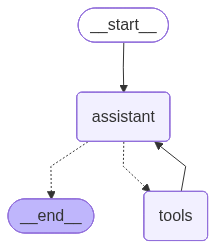

In [ ]:
# Show
display(Image(react_graph_memory.get_graph(xray=True).draw_mermaid_png()))

## Thread

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


## Invoke the Graph for the First Time

In [ ]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_c4AxNtAh4gabbyROZEkUfDJ5)
 Call ID: call_c4AxNtAh4gabbyROZEkUfDJ5
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


If we pass the same `thread_id`, then we can proceed from from the previously logged state checkpoint!

In this case, the above conversation is captured in the thread.

The `HumanMessage` we pass (`"Multiply that by 2."`) is appended to the above conversation.

So, the model now know that `that` refers to the `The sum of 3 and 4 is 7.`.

## Invoke the Graph for the Second Time

#### Using the same config (thread id).

In [ ]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_c4AxNtAh4gabbyROZEkUfDJ5)
 Call ID: call_c4AxNtAh4gabbyROZEkUfDJ5
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_vXb5lh3NMGO1aTqY2EJRHytT)
 Call ID: call_vXb5lh3NMGO1aTqY2EJRHytT
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multipl

## Invoke the Graph for the Third Time

#### Using the same config (thread id).

In [ ]:
messages = [HumanMessage(content="Divide that by 5.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_c4AxNtAh4gabbyROZEkUfDJ5)
 Call ID: call_c4AxNtAh4gabbyROZEkUfDJ5
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_vXb5lh3NMGO1aTqY2EJRHytT)
 Call ID: call_vXb5lh3NMGO1aTqY2EJRHytT
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multipl

## Now Try with a Different Config

#### This is a **New Thread**.
#### The content of the old config is lost, so the LLM is not able to retriev the previous context.


In [ ]:
# Specify a new thread
config = {"configurable": {"thread_id": "2"}}

messages = [HumanMessage(content="Add that by 6.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 6.
================================== Ai Message ==================================

Please provide the number you would like to multiply by 6.
================================ Human Message =================================

Add that by 6.
================================== Ai Message ==================================

It seems you want to perform two operations (multiplying and then adding). Could you confirm the initial number you would like to use for these calculations?


## Reuse the Old Config

In [ ]:
# Specify a new thread
config = {"configurable": {"thread_id": "1"}}

messages = [HumanMessage(content="Add that by 6.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_c4AxNtAh4gabbyROZEkUfDJ5)
 Call ID: call_c4AxNtAh4gabbyROZEkUfDJ5
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_vXb5lh3NMGO1aTqY2EJRHytT)
 Call ID: call_vXb5lh3NMGO1aTqY2EJRHytT
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multipl